***
### Import of required libraries
***

In [1]:
from traffic.core import Traffic
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

***
#### Import and preparation of data
***

##### Trajectory data

In [ ]:
# Path to folder containing traffic files
traj_path = "/mnt/beegfs/store/Projects_CRM/RAD_paper/trajectories/new/"

# Definition of relevant city pairs
pairs = [
    ("EGKK", "LSZH", "london_to_zurich_EGKK.parquet"),
    ("EGLC", "LSZH", "london_to_zurich_EGLC.parquet"),
    ("EGLL", "LSZH", "london_to_zurich_EGLL.parquet"),
    ("LSZH", "EGKK", "zurich_to_london_EGKK.parquet"),
    ("LSZH", "EGLC", "zurich_to_london_EGLC.parquet"),
    ("LSZH", "EGLL", "zurich_to_london_EGLL.parquet"),
]

# Generation of dataframe containing flight_id, callsign and date over all
# flights for all city pairs
dfs = []
for pair in pairs:
    print(f"processing {pair[0]} -> {pair[1]}")
    flights = Traffic.from_file(traj_path + pair[2])
    flight_ids = []
    callsigns = []
    dates = []
    for flight in flights:
        flight_ids.append(flight.flight_id)
        callsigns.append(flight.callsign)
        dates.append(flight.start.date())
    df = pd.DataFrame(
        {
            "flight_id": flight_ids,
            "callsign": callsigns,
            "date": dates,
        }
    )
    dfs.append(df)
osn_df = pd.concat(dfs)

##### Flightplan data

In [ ]:
# Load flightplan data
flightplan_path = "/mnt/beegfs/store/Projects_CRM/RAD_paper/flightplans/flightplans_complete.parquet"
flightplans = pd.read_parquet(flightplan_path)
flightplans = flightplans[flightplans['operator'].isin(['SWR', 'BAW', 'EZY'])]

# Generate a dataframe containing identifier, callsign and date for all flights
# contained in the flightplan data
ids = flightplans.identifier.unique()
identifiers = []
callsigns = []
dates = []
times = []
for id in tqdm(ids):
    temp = flightplans[flightplans.identifier == id]
    identifiers.append(temp.iloc[0].identifier)
    callsigns.append(temp.iloc[0].callsign)
    dates.append(temp.iloc[0].segment_start_d)
    times.append(temp.iloc[0].segment_start_t)
flightplans_df = pd.DataFrame(
    {
        "identifier": identifiers,
        "callsign": callsigns,
        "date": dates,
        "time": times,
    }
)
flightplans_df

***
### Data matching
***

##### Matching dataframe matching identifier and flight_id based on callsign and date

In [ ]:
match_df = pd.merge(
    left=flightplans_df,
    right=osn_df,
    left_on=["date", "callsign"],
    right_on=["date", "callsign"],
    how="inner",
)
match_df

##### Grouping multiple flights per combination of callsign and date

In [ ]:
match_df = (
    match_df.groupby(["date", "callsign"], as_index=False)
    .agg(
        {
            "flight_id": lambda x: tuple(x),
            "identifier": "first",
        }
    )
    .drop(columns=["date", "callsign"])
)
match_df

##### Add flight_id to flightplan

In [ ]:
flightplans = pd.merge(
    left=flightplans,
    right=match_df,
    left_on="identifier",
    right_on="identifier",
    how="left",
)

##### Remove flights without assigned trajectories

In [ ]:
print(flightplans.identifier.nunique())
flightplans = flightplans.dropna(subset=["flight_id"])
flightplans.identifier.nunique()

##### Remove flight without unique assignment

In [ ]:
print(flightplans.identifier.nunique())
flightplans = flightplans[flightplans['flight_id'].apply(lambda x: len(x) == 1)]
print(flightplans.identifier.nunique())

##### Save

In [ ]:
flightplans.to_parquet(
    "/mnt/beegfs/store/Projects_CRM/RAD_paper/flightplans/flightplans_complete_with_flight_id.parquet"
)

***
### Analysis
***

In [2]:
flightplans = pd.read_parquet(
    "/mnt/beegfs/store/Projects_CRM/RAD_paper/flightplans/flightplans_complete_with_flight_id.parquet"
)

In [3]:
flightplans_grouped = flightplans.groupby("identifier").agg(
    {
        "origin": "first",
        "destination": "first",
        "operator": "first",
        "ac_type": "first",
        "segment_start_d": "first",
        "segment_start_t": "first",
    }
)

##### Amount per route

In [4]:
print(f"LSZH -> EGKK: {len(flightplans_grouped[(flightplans_grouped.origin == 'LSZH')&(flightplans_grouped.destination == 'EGKK')])}")
print(f"EGKK -> LSZH: {len(flightplans_grouped[(flightplans_grouped.origin == 'EGKK')&(flightplans_grouped.destination == 'LSZH')])}")
print(f"LSZH -> EGLC: {len(flightplans_grouped[(flightplans_grouped.origin == 'LSZH')&(flightplans_grouped.destination == 'EGLC')])}")
print(f"EGLC -> LSZH: {len(flightplans_grouped[(flightplans_grouped.origin == 'EGLC')&(flightplans_grouped.destination == 'LSZH')])}")
print(f"LSZH -> EGLL: {len(flightplans_grouped[(flightplans_grouped.origin == 'LSZH')&(flightplans_grouped.destination == 'EGLL')])}")
print(f"EGLL -> LSZH: {len(flightplans_grouped[(flightplans_grouped.origin == 'EGLL')&(flightplans_grouped.destination == 'LSZH')])}")

LSZH -> EGKK: 418
EGKK -> LSZH: 430
LSZH -> EGLC: 762
EGLC -> LSZH: 1018
LSZH -> EGLL: 2263
EGLL -> LSZH: 3120


##### Amount per airline

In [5]:
print(f"SWR: {len(flightplans_grouped[flightplans_grouped.operator == 'SWR'])}")
print(f"BAW: {len(flightplans_grouped[flightplans_grouped.operator == 'BAW'])}")
print(f"EZY: {len(flightplans_grouped[flightplans_grouped.operator == 'EZY'])}")

SWR: 5186
BAW: 2022
EZY: 803


##### Amount per type

In [6]:
flightplans_grouped.ac_type.value_counts()

ac_type
A20N    1993
A320    1242
E290    1186
A319    1029
BCS1     797
BCS3     776
A21N     663
E295     177
A321     100
E190      48
Name: count, dtype: int64

##### Distribution over time

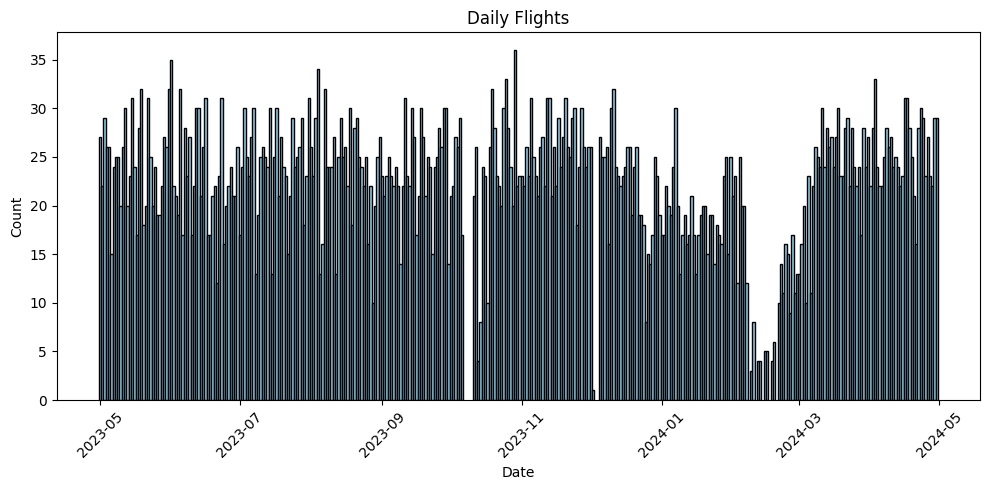

In [7]:
date_grouped = flightplans_grouped.groupby(flightplans_grouped['segment_start_d']).size().reset_index(name='count')

plt.figure(figsize=(10, 5))
plt.bar(date_grouped["segment_start_d"], date_grouped["count"], width=1.0, color="skyblue", edgecolor="black")
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Daily Flights")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Percentage of available flightplans

In [8]:
full_flightplan = pd.read_parquet(
    "/mnt/beegfs/store/Projects_CRM/RAD_paper/flightplans/flightplans_complete.parquet"
)
full_flightplan = full_flightplan[full_flightplan['operator'].isin(['SWR', 'BAW', 'EZY'])]
full_flightplan = full_flightplan.groupby("identifier").agg(
    {
        "origin": "first",
        "destination": "first",
    }
)
reduced = pd.read_parquet(
    "/mnt/beegfs/store/Projects_CRM/RAD_paper/flightplans/flightplans_complete_with_flight_id.parquet"
)
reduced = reduced.groupby("identifier").agg(
    {
        "origin": "first",
        "destination": "first",
    }
)

print(f"LSZH -> EGKK: {round(100*len(reduced[(reduced.origin == 'LSZH')&(reduced.destination == 'EGKK')])/len(full_flightplan[(full_flightplan.origin == 'LSZH')&(full_flightplan.destination == 'EGKK')]),1)}%")
print(f"EGKK -> LSZH: {round(100*len(reduced[(reduced.origin == 'EGKK')&(reduced.destination == 'LSZH')])/len(full_flightplan[(full_flightplan.origin == 'EGKK')&(full_flightplan.destination == 'LSZH')]),1)}%")
print(f"LSZH -> EGLC: {round(100*len(reduced[(reduced.origin == 'LSZH')&(reduced.destination == 'EGLC')])/len(full_flightplan[(full_flightplan.origin == 'LSZH')&(full_flightplan.destination == 'EGLC')]),1)}%")
print(f"EGLC -> LSZH: {round(100*len(reduced[(reduced.origin == 'EGLC')&(reduced.destination == 'LSZH')])/len(full_flightplan[(full_flightplan.origin == 'EGLC')&(full_flightplan.destination == 'LSZH')]),1)}%")
print(f"LSZH -> EGLL: {round(100*len(reduced[(reduced.origin == 'LSZH')&(reduced.destination == 'EGLL')])/len(full_flightplan[(full_flightplan.origin == 'LSZH')&(full_flightplan.destination == 'EGLL')]),1)}%")
print(f"EGLL -> LSZH: {round(100*len(reduced[(reduced.origin == 'EGLL')&(reduced.destination == 'LSZH')])/len(full_flightplan[(full_flightplan.origin == 'EGLL')&(full_flightplan.destination == 'LSZH')]),1)}%")

LSZH -> EGKK: 65.0%
EGKK -> LSZH: 67.2%
LSZH -> EGLC: 60.7%
EGLC -> LSZH: 81.1%
LSZH -> EGLL: 53.1%
EGLL -> LSZH: 73.2%
